In [1]:
import os
from typing import Literal, Annotated, TypedDict
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
load_dotenv()

True

In [3]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [6]:
llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [7]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

In [8]:
clean_text(llm.invoke("hi").content)

'Hello! How can I assist you today? 😊'

In [9]:
tavily_tool = TavilySearchResults()

In [10]:
tavily_tool.invoke("What is GDP?")

[{'title': 'Gross Domestic Product - National Geographic Education',
  'url': 'https://education.nationalgeographic.org/resource/gross-domestic-product/',
  'content': 'Gross domestic product, or GDP, represents the total dollar value of all goods and services produced in a country in a given period. GDP is often used to track the growth of a country’s economy. Officials associate the number with prosperity when it is high. GDP helps to identify a society’s standard of living and income; it is an accepted measure of productivity in a society. In the most general sense, GDP is an indication of the size of a country’s economy. [...] ## ENCYCLOPEDIC ENTRY\n\n## ENCYCLOPEDIC ENTRY\n\n# Gross Domestic Product\n\n# Gross Domestic Product\n\nGross domestic product (GDP)**,** the total value of all goods and services produced in a country in a given period, is one method to determine a country’s economic growth, and therefore success—but it is not necessarily always the most accurate.\n\n### G

In [11]:
code = """
x = 5
y = x * 2
print(y)
"""

In [12]:
repl = PythonREPL()
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [13]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with 'print(...)'. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

In [14]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [15]:
members = ["researcher", "coder"]

In [16]:
options = members+["FINISH"]

In [17]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["researcher", "coder", "FINISH"]

In [18]:
class State(MessagesState):
    next: str

In [19]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""

In [20]:
def supervisor_node(state:State) -> Command[Literal["researcher", "coder", "__end__"]]:
    messages = [{"role":"system", "content": system_prompt},] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print("below my goto****************************")
    print(goto)
    if goto == "FINISH":
        goto == END
    return Command(goto=goto, update={"next":goto})

In [21]:
def research_node(state:State) -> Command[Literal["supervisor"]]:
    research_agent = create_react_agent(llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math.")
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto = "supervisor"
    )

In [22]:
def code_node(state:State) -> Command[Literal["supervisor"]]:
    code_agent = create_react_agent(llm, tools=[python_repl_tool])
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto = "supervisor"
    )

In [23]:
graph = StateGraph(State)
graph.add_node("supervisor", supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)
graph.add_edge(START, "supervisor")
app = graph.compile()

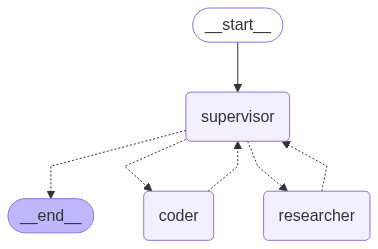

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
for s in app.stream({"messages":[("user","What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("-------")

below my goto****************************
coder
((), {'supervisor': {'next': 'coder'}})
-------
(('coder:1978970b-0ade-d6f3-3fac-eecf21df3850',), {'agent': {'messages': [AIMessage(content='The square root of 42 is approximately 6.4807. This means that 6.4807 multiplied by itself is roughly equal to 42.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 532, 'prompt_tokens': 173, 'total_tokens': 705, 'completion_time': 1.9345454549999999, 'prompt_time': 0.010907474, 'queue_time': 0.054074901999999994, 'total_time': 1.945452929}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--934ff5ff-82c3-4bff-8598-22182b7debcd-0', usage_metadata={'input_tokens': 173, 'output_tokens': 532, 'total_tokens': 705})]}})
-------
((), {'coder': {'messages': [HumanMessage(content='The square root of 42 is approximately 6.4807. This means that 6.4807 multiplied by itself is roughly equal to 42

In [26]:
app.invoke({"messages":[("user","What's the square root of 42?")]}, subgraphs=True)

below my goto****************************
coder
below my goto****************************
researcher
below my goto****************************
researcher
below my goto****************************
FINISH


((),
 {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='4797beee-9365-47bf-8ca1-72e124976100'),
   HumanMessage(content='The square root of 42 is approximately 6.48074069840786.', additional_kwargs={}, response_metadata={}, name='coder', id='a1381fca-68a8-414d-9906-0ff31aa09083'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='dcd14757-09af-4bb3-8189-fd257e674ad3'),
   HumanMessage(content='The square root of 42 is approximately 6.4807. This value was determined by recognizing that 42 is not a perfect square and using the long division method to approximate its square root. The calculation confirms that 6.4807 multiplied by itself is close to 42, validating the result.', additional_kwargs={}, response_metadata={}, name='researcher', id='e1051d49-3320-41fd-9fd5-0a1eee3a8096')],
  'next': 'FINISH'})

In [27]:
app.invoke({"messages":[("user","What is an efficient Python code to get prime numbers.")]}, subgraphs=True)

below my goto****************************
coder
below my goto****************************
coder
below my goto****************************
coder
below my goto****************************
coder
below my goto****************************
coder
below my goto****************************
researcher
below my goto****************************
researcher
below my goto****************************
researcher
below my goto****************************
researcher


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\nHere\'s an efficient Python code to generate prime numbers using the Sieve of Eratosthenes algorithm and a helper function to check if a number is prime:\n\n```python\ndef sieve_of_eratosthenes(limit):\n    """Generate list of primes up to the given limit using Sieve of Eratosthenes."""\n    if limit < 2:\n        return []\n    sieve = [True] * (limit + 1)\n    sieve[0], sieve[1] = False, False  # 0 and 1 are not primes\n    \n    for current in range(2, int(limit ** 0.5) + 1):\n        if sieve[current]:  # If current is a prime\n            # Mark multiples of current as not prime\n            for multiple in range(current * current, limit + 1, current):\n                sieve[multiple] = False\n                \n    primes = [num for num, is_prime in enumerate(sieve) if is_prime]\n    return primes\n\ndef is_prime(n):\n    """Check if a number is prime using trial division up to sqrt(n)."""\n    if n <= 1:\n        return False\n    if n <= 3:\n        return True\n    if n % 2 == 0 or n % 3 == 0:\n        return False\n    \n    i = 5\n    w = 2\n    while i * i <= n:\n        if n % i == 0:\n            return False\n        i += w\n        w = 6 - w  # Alternate between adding 2 and 4 (5, 7, 11, 13, etc.)\n    \n    return True\n\n# Example usage\nif __name__ == "__main__":\n    # Generate all primes up to 100\n    primes_up_to_100 = sieve_of_eratosthenes(100)\n    print("Primes up to 100:", primes_up_to_100)\n    \n    # Check if 101 is a prime number\n    is_101_prime = is_prime(101)\n    print("Is 101 a prime number?", is_101_prime)\n```\n\n### Explanation\n\n1. **Sieve of Eratosthenes**:\n   - This function generates all prime numbers up to a specified limit.\n   - It initializes a boolean list where each index represents whether the number is prime.\n   - Non-prime numbers are marked as `False` by iterating through each prime and marking its multiples.\n\n2. **Prime Checking Function**:\n   - This function checks if a single number is prime using trial division up to the square root of the number.\n   - It skips even numbers and multiples of 3 for efficiency.\n\n### Output\n\nWhen you run this code, you should see:\n\n```\nPrimes up to 100: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]\nIs 101 a prime number? True\n```\n\nThis code efficiently generates primes up to a given limit and checks individual numbers for primality, making it versatile for different use cases.'}}